In [1]:
%matplotlib inline
#some basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

#TODO: add your imports here


#seting up some styles
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")

#avoid Font-problem in plots for ACM/IEEE papers
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

experiment_name = "Tracing"

In [2]:
from load import load
activations,perfromance = load()

experimentes = perfromance["experiment"].unique()

## Experiment Plots

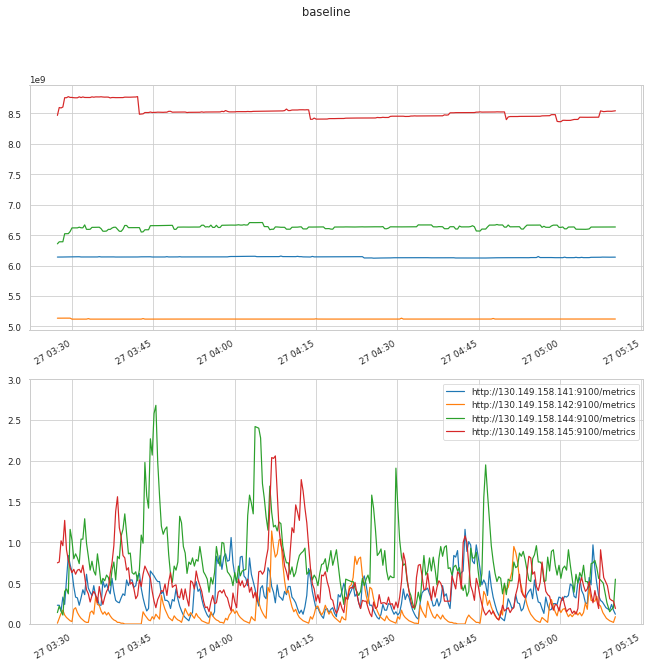

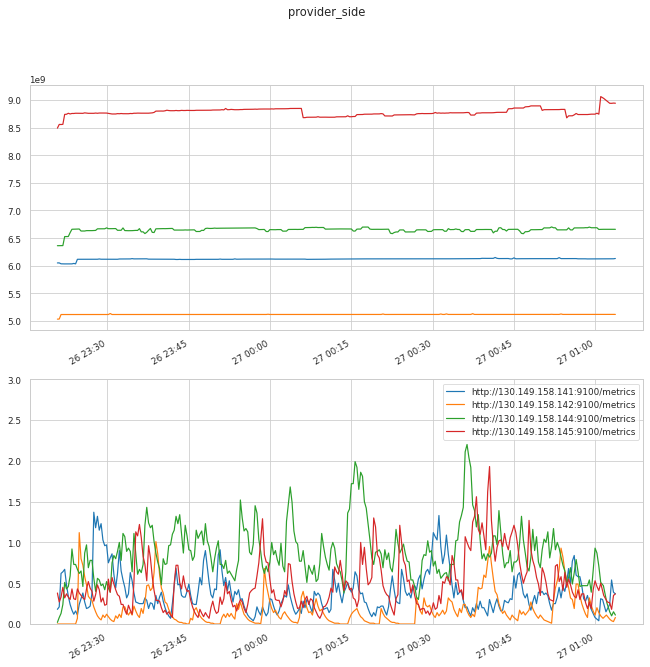

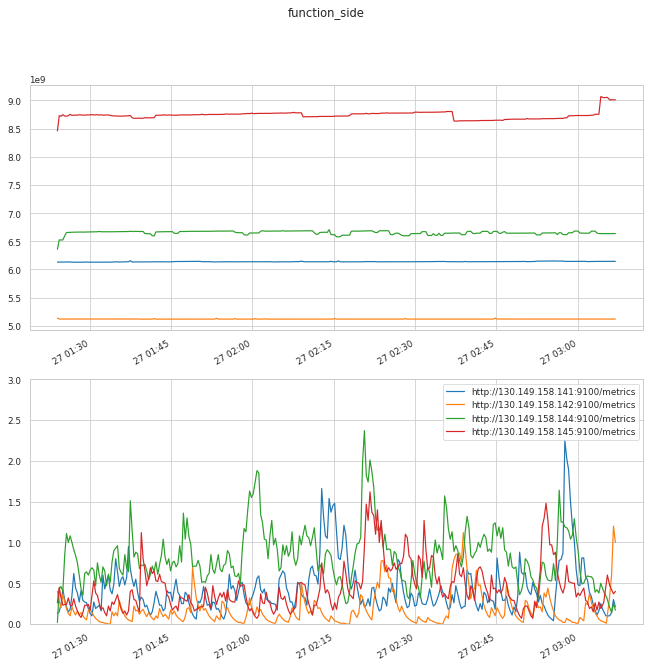

In [3]:
for exp in experimentes:
    fig = plt.figure(figsize=(11,11))
    gs = fig.add_gridspec(ncols=1, nrows=2,hspace=0.20)
    X = perfromance[perfromance["experiment"] == exp]
    mem = X.groupby(["node"]).resample("5m")["node_memory_Active"]
    ax = fig.add_subplot(gs[0])
    mem.plot(ax=ax)

    cpu = X.groupby(["node"]).resample("5m")["node_load1"]
    ax = fig.add_subplot(gs[1])
    cpu.plot(ax=ax)
    ax.set_ylim([0.0,3.0])
    plt.legend()
    plt.suptitle(exp)



In [5]:
activations['start'] = pd.to_datetime(activations['start'],unit='ms')
activations['end'] = pd.to_datetime(activations['end'],unit='ms')

activations["ELat"] = (activations["end"] - activations["start"]).dt.total_seconds()

activations.groupby(["enviroment","experiment"])["ELat"].describe()


count       mean        std    min      25%  \
enviroment    experiment                                                   
data/failiure function_side   30.0  57.751467  39.655205  0.325  1.77775   
              provider_side   28.0  54.000857  39.729402  0.073  0.43950   
data/normal   baseline       296.0  51.838966  39.408884  0.005  0.43500   
              function_side  290.0  51.059090  39.339011  0.012  0.47750   
              provider_side  296.0  52.813331  39.253060  0.012  0.52550   

                                 50%       75%      max  
enviroment    experiment                                 
data/failiure function_side  84.3775  86.01900   97.485  
              provider_side  79.2945  84.64025   90.247  
data/normal   baseline       75.4470  77.78950  121.909  
              function_side  78.5950  80.88675  198.414  
              provider_side  78.9165  81.25075  204.264

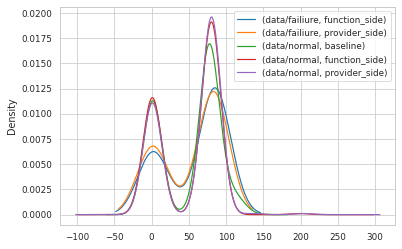

In [9]:
activations.groupby(["enviroment","experiment"])["ELat"].plot.kde()
plt.legend()

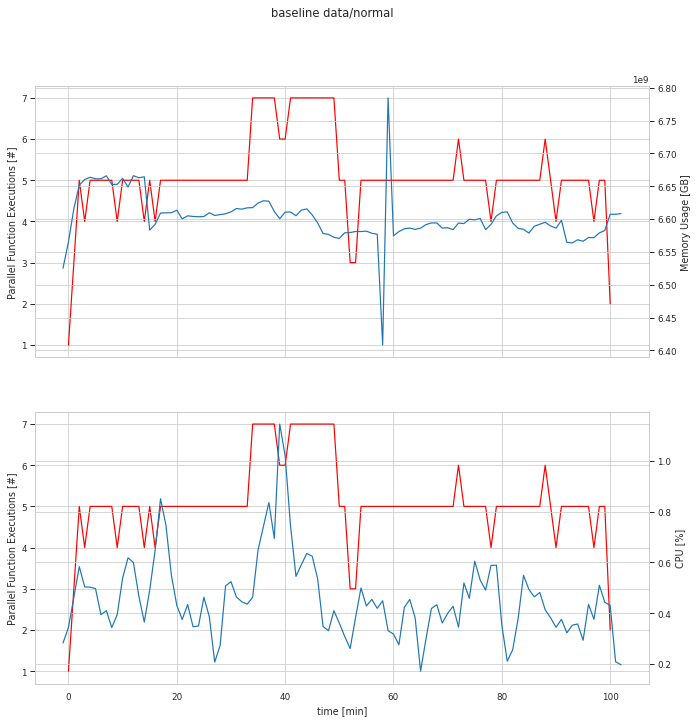

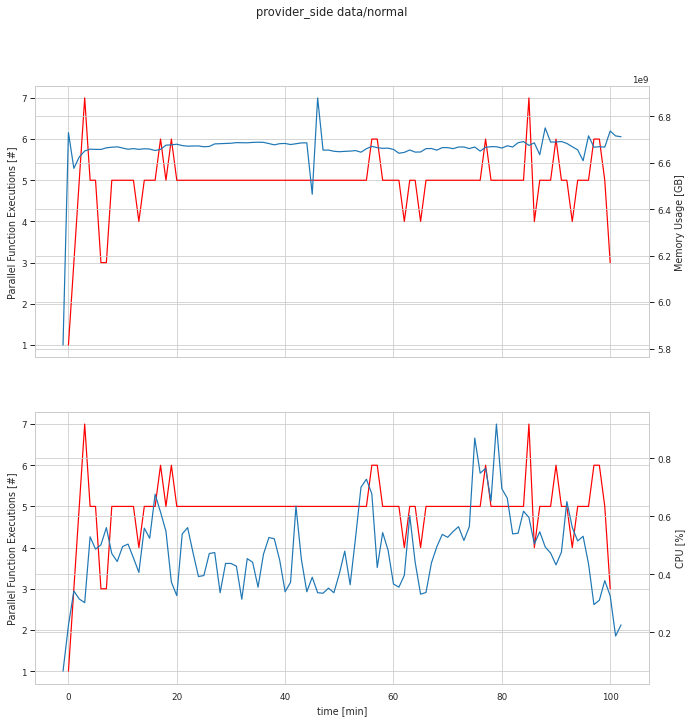

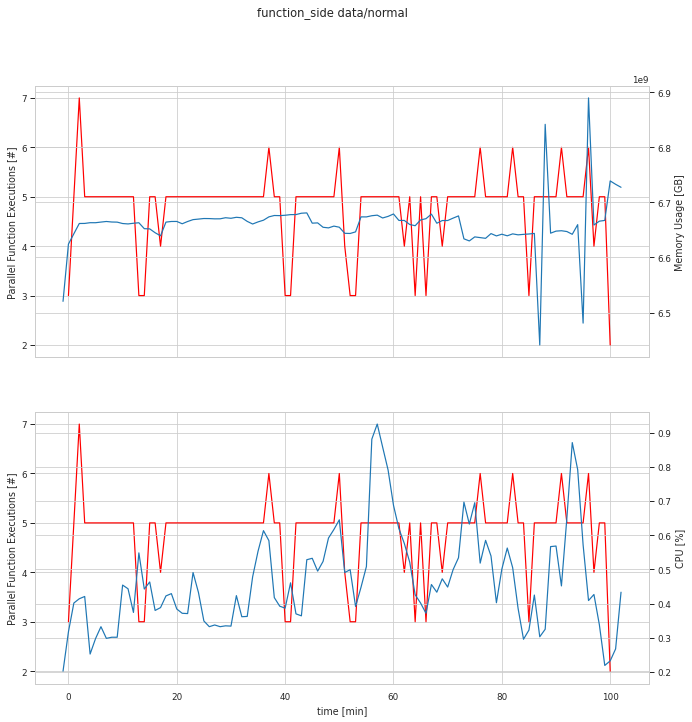

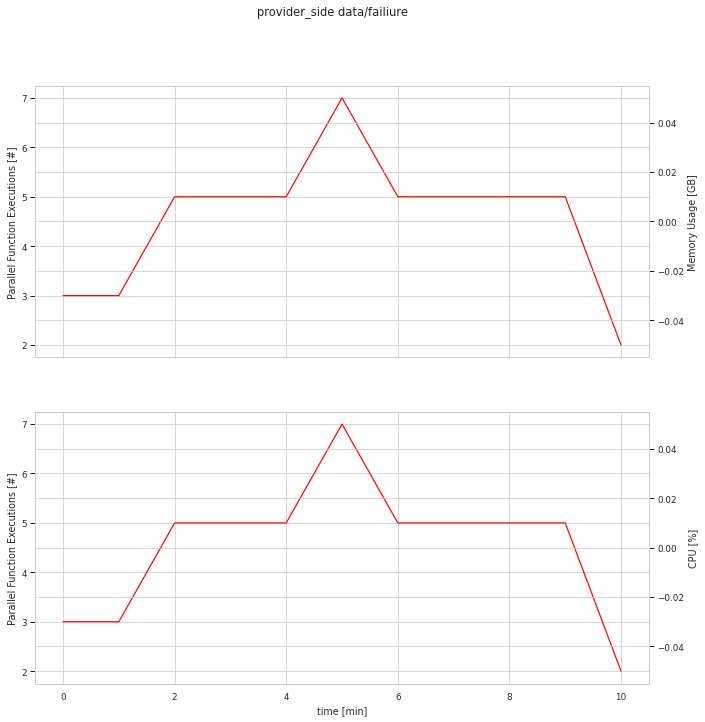

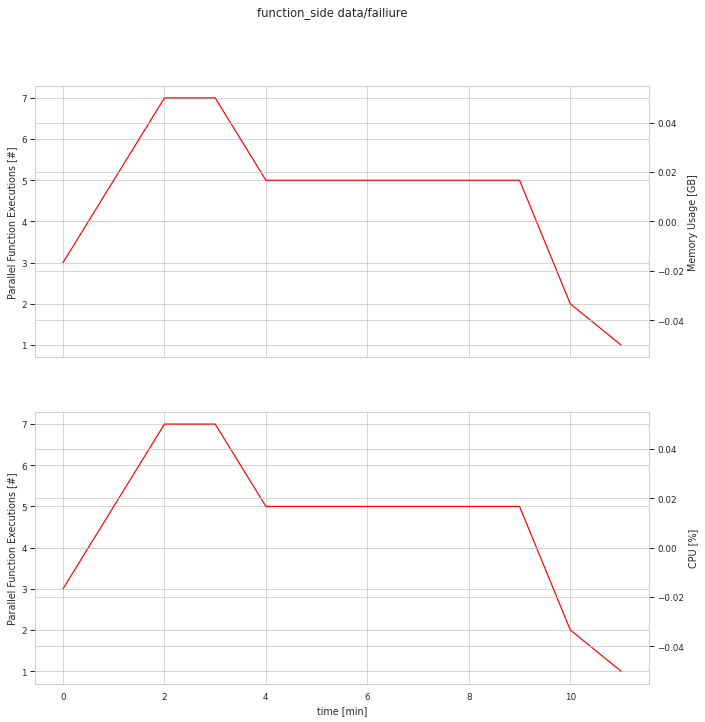

In [20]:
for env  in activations["enviroment"].unique():
    for exp in experimentes:
        X = activations[activations["enviroment"] == env]
        X = X[X["experiment"] == exp]
        if len(X) <= 0:
            continue
        experimentLengthInMinutes = round((X["end"].max()-X["start"].min()).total_seconds()/60)
        experimentStartTime = X["start"].min()
        executions = np.zeros(experimentLengthInMinutes+1)
        for i,a in X.iterrows():
            start = round((a["start"]-experimentStartTime).total_seconds()/60)
            end = round((a["end"]-experimentStartTime).total_seconds()/60)
            for i in range(start,end):
                executions[i] +=1
            executions[end] +=1

        Y = perfromance[perfromance["experiment"] == exp]
        Y = Y[Y["enviroment"] == env]
        #timeshift to corrent for provider side time?
        Y.index = Y.index.shift(-2,freq="h")
        Y[Y.index < X["end"].max()]
        Y["EStart"] = (Y.index-experimentStartTime).total_seconds()//60
        mem = Y.groupby(["EStart"])["node_memory_Active"].mean()
        cpu = Y.groupby(["EStart"])["node_load1"].mean()
        fig = plt.figure(figsize=(11,11))
        plt.suptitle(exp+" "+env)
        gs = fig.add_gridspec(ncols=1, nrows=2,hspace=0.20)
        ax = fig.add_subplot(gs[0])
        sns.lineplot(range(0,len(executions)),executions,ax=ax,color="r")
        ax.set_ylabel("Parallel Function Executions [#]")
        ax.set_xlabel("time [min]")

        ax = ax.twinx()
        mem.plot(ax=ax)
        ax.set_ylabel("Memory Usage [GB]")
        

        ax = fig.add_subplot(gs[1])
        sns.lineplot(range(0,len(executions)),executions,ax=ax,color="r")
        ax.set_ylabel("Parallel Function Executions [#]")
        ax.set_xlabel("time [min]")
        ax = ax.twinx()
        cpu.plot(ax=ax)
        ax.set_ylabel("CPU [%]")
   




In [18]:
for env  in activations["enviroment"].unique():
    for exp in experimentes:
        X = activations[activations["experiment"] == exp]
        X = X[X["enviroment"] == env]
        print(X["end"].max(),X["start"].min(),env,exp)

2020-08-27 03:07:40.502000 2020-08-27 01:27:17.797000 data/normal baseline
2020-08-26 23:01:16.128000 2020-08-26 21:20:47.837000 data/normal provider_side
2020-08-27 01:04:24.179000 2020-08-26 23:24:02.625000 data/normal function_side
NaT NaT data/failiure baseline
2020-08-31 09:47:09.393000 2020-08-31 09:36:43.567000 data/failiure provider_side
2020-08-31 10:31:20.410000 2020-08-31 10:20:48.543000 data/failiure function_side


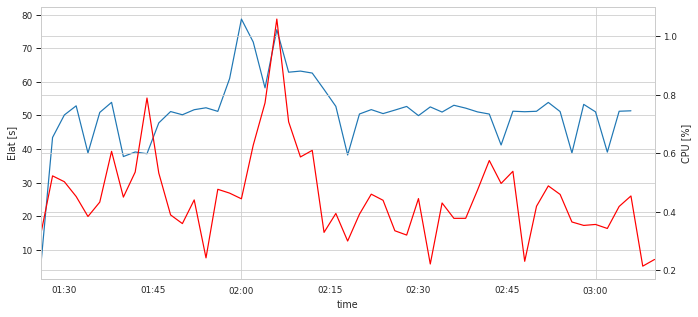

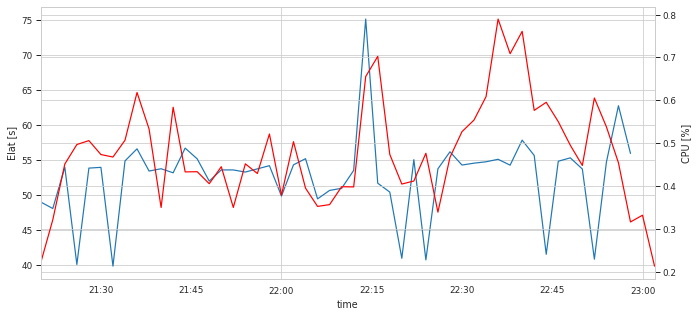

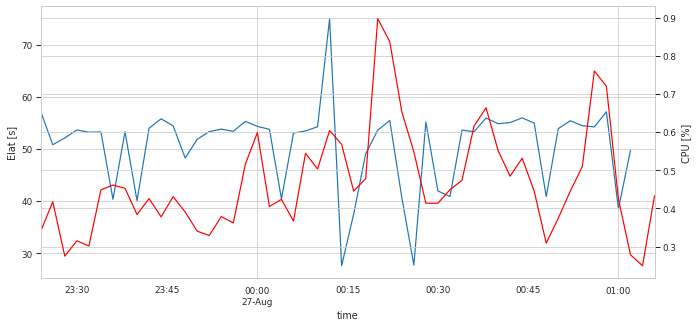

In [40]:
for exp in experimentes:
    fig = plt.figure(figsize=(11,5))
    gs = fig.add_gridspec(ncols=1, nrows=1,hspace=0.20)
    X = activations[activations["experiment"] == exp]
    ax = fig.add_subplot(gs[0])
    X.set_index("start").resample("2min")["ELat"].mean().plot(ax=ax)
    ax.set_ylabel("Elat [s]")
    ax.set_xlabel("time")
    X = perfromance[perfromance["experiment"] == exp]
    X.index = X.index.shift(-2,freq="h")
    cpu = X.resample("2min")["node_load1"].mean()
    ax = ax.twinx()
    ax.set_ylabel("CPU [%]")
    
    cpu.plot(ax=ax,color="r")

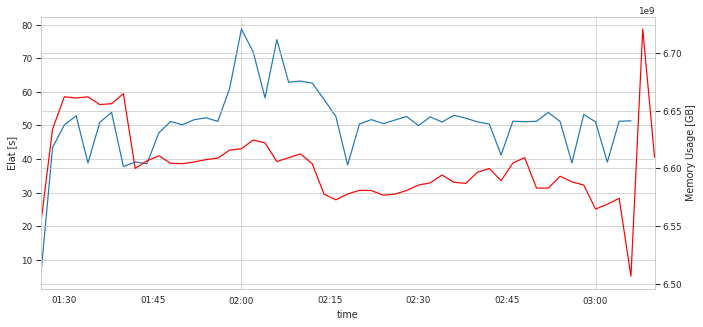

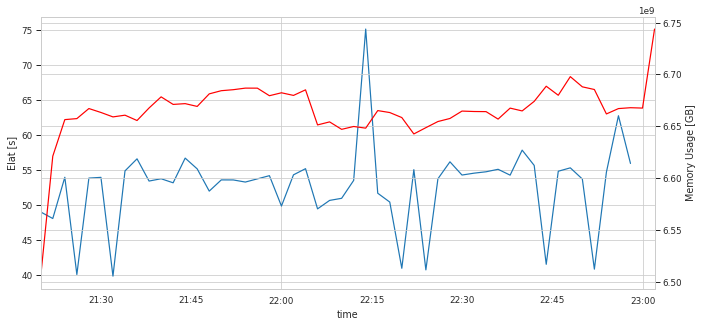

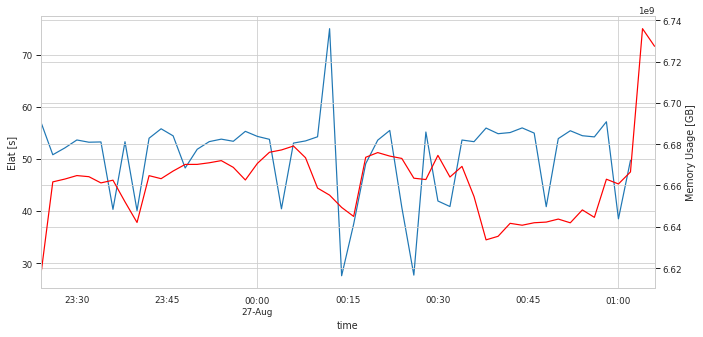

In [42]:
for exp in experimentes:
    fig = plt.figure(figsize=(11,5))
    gs = fig.add_gridspec(ncols=1, nrows=1,hspace=0.20)
    X = activations[activations["experiment"] == exp]
    ax = fig.add_subplot(gs[0])
    X.set_index("start").resample("2min")["ELat"].mean().plot(ax=ax)
    ax.set_ylabel("Elat [s]")
    ax.set_xlabel("time")
    X = perfromance[perfromance["experiment"] == exp]
    X.index = X.index.shift(-2,freq="h")
    cpu = X.resample("2min")["node_memory_Active"].mean()
    ax = ax.twinx()
    ax.set_ylabel("Memory Usage [GB]")
    
    cpu.plot(ax=ax,color="r")